# Data exploration

There are several interesting questions to ask. The articles below pose several observations made by survivors. We would like to validate these observations with the data.

https://en.wikipedia.org/wiki/RMS_Titanic#Sinking
https://www.encyclopedia-titanica.org/titanic-deckplans/c-deck.html
https://en.wikipedia.org/wiki/Lifeboats_of_the_RMS_Titanic


Were women and children more likely to survive?
Were third class passengers much less likely to survive?
Are cabins on port or starboard more likely to survive?


In [380]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from IPython.core.display import display, HTML

filename = 'titanic_data.csv'
df = pd.read_csv(filename)

def pprint_df(df):
    if type(df) == pd.DataFrame:
        display(HTML(df.to_html()))
    elif type(df) == pd.Series:
        display(HTML(df.to_frame().to_html()))

df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [216]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Overall Survival

Overall survival proportion:  0.383838383838


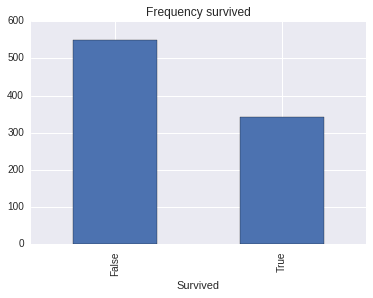

In [237]:
# Create a copy of the original
df2 = df.copy(deep=True)
# Update the survived Type
df2.Survived = df2.Survived.apply(lambda x: True if x else False)

grouped_survived = df2.groupby('Survived').count()['PassengerId']
grouped_survived.plot(kind='bar', title='Frequency survived')
print 'Overall survival proportion: ', grouped_survived[True] / float(grouped_survived.sum())

# Survival vs Age

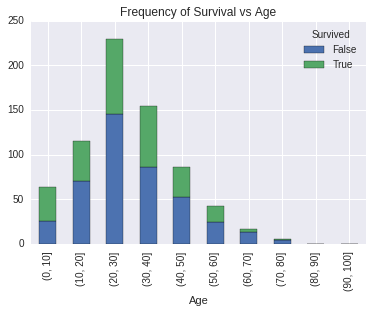

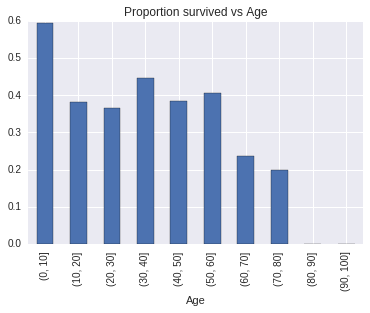

In [396]:
# Create age groups
age_groups = np.array([0,10,20,30,40,50,60,70,80,90,100])
# Group data by Survived and age group
grouped_survived_age = df2.groupby(['Survived',pd.cut(df2['Age'],age_groups)]).count()
grouped_survived_age = grouped_survived_age['PassengerId']
grouped_survived_age = grouped_survived_age.rename('Frequency')
grouped_survived_age = grouped_survived_age.unstack().transpose()
grouped_survived_age.plot(kind = 'bar', stacked=True, title = 'Frequency of Survival vs Age')
plt.show()
# Describe the proportion of survival per age group
survived_age_proportion = grouped_survived_age[True] / (grouped_survived_age[False] + grouped_survived_age[True])
survived_age_proportion.plot(kind='bar', y='Proportion of Survived', title='Proportion survived vs Age')

There is not a clear relationship between age and survival. However, the youngest and oldest have an inverse relationship with survival. The youngest passengers have the best survival rate and the oldest have the worst survival rate.

# Survival vs Gender

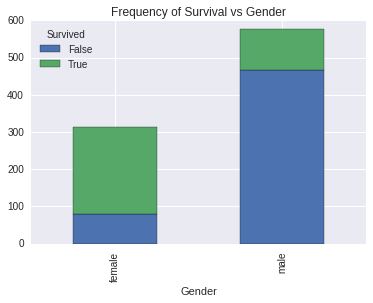

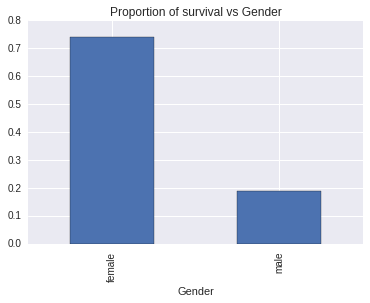

In [137]:
grouped_survival_gender = df2.rename(columns={'Sex': 'Gender'})
grouped_survival_gender = grouped_survival_gender[['Gender','Survived','PassengerId']].groupby(['Survived','Gender']).count()
grouped_survival_gender = grouped_survival_gender['PassengerId'].rename('Frequency').unstack()
grouped_survival_gender = grouped_survival_gender.transpose()
grouped_survival_gender.plot(kind='bar', stacked=True, title='Frequency of Survival vs Gender')
plt.show()
survival_gender_proportion = grouped_survival_gender[True] / (grouped_survival_gender[True] + grouped_survival_gender[False])
survival_gender_proportion.plot(kind='bar',title='Proportion of survival vs Gender')

Females appear to have a significantly better survival rate than men. We will need to determine if this difference is statistically significant. For the independent variable, gender, we will use a chi-squared goodness-of-fit test to determine if the observed frequencies for female passengers fits the expected survivability.

Null Hypothesis: Gender and survivability are independent

Alternate Hypothesis: Gender and survivability are not independent

http://hamelg.blogspot.com/2015/11/python-for-data-analysis-part-25-chi.html

In [367]:


confidence = 0.95
df = 1
total_survival = grouped_survived.sum()
female_survival = grouped_survival_gender.loc['female']
expected_ratios = grouped_survived / total_survival
expected_counts = female_survival.sum() * expected_ratios

chi_squared_stat = (((female_survival-expected_counts)**2)/expected_counts).sum()
crit = stats.chi2.ppf(q=confidence, df=df)
p_value = 1 - stats.chi2.cdf(x=chi_squared_stat, df=df)

# Confirm our result using the automated results
results = stats.chisquare(f_obs= female_survival,f_exp= expected_counts)

print 'total survival: ', total_survival
print 'chi-squared value: ', chi_squared_stat
print 'Critical value: ', crit
print 'p-value: ', p_value
print results

total survival:  891
chi-squared value:  170.348127092
Critical value:  3.84145882069
p-value:  0.0
Power_divergenceResult(statistic=170.34812709177143, pvalue=6.2105848997692429e-39)


Validating our assumptions for the chi-squared test:

- [x] Observations are indepedent
- [x] Categories are mututally exclusive
- [x] Expected frequencies > 5

Presenting the results:

$$
chi^2-squared(1, N=891) = 170.348, P < .05
$$

At a confidence level of 95%, this is very statistically significant. Gender is not independent of survivability.

https://pythonfordatascience.org/chi-square-python/

# Survival vs Passenger Class

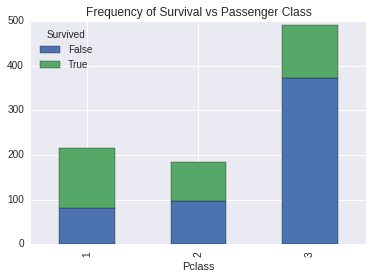

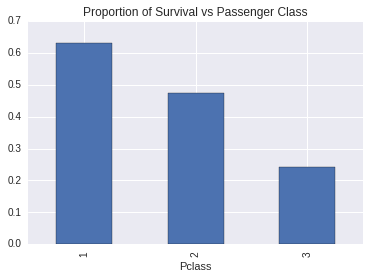

In [154]:
grouped_survival_class = df2[['Survived','Pclass','PassengerId']].groupby(['Survived','Pclass']).count()
grouped_survival_class = grouped_survival_class['PassengerId'].rename('Frequency').unstack()
grouped_survival_class = grouped_survival_class.transpose()
grouped_survival_class.plot(kind='bar',stacked=True,title='Frequency of Survival vs Passenger Class')
plt.show()
survival_class_proportion = grouped_survival_class[True] / grouped_survival_class.sum(axis=1)
survival_class_proportion.plot(kind='bar',title='Proportion of Survival vs Passenger Class')

There appears to be a correlation between passenger class and survival. We will need to test this further. Once again, we will use a chi-squared test.

In [383]:
total_survival = grouped_survived.sum()
expected_ratios = grouped_survived / total_survival
passengers_by_class = grouped_survival_class.sum(axis=1)

# Manual calculation of chi-squared expected values
zero_data = np.zeros(shape=(len(expected_ratios),len(passengers_by_class)))
rows = passengers_by_class.keys()
columns = expected_ratios.keys()
d = pd.DataFrame(zero_data, columns=rows, index=columns)
expected_counts = (d + passengers_by_class).multiply(expected_ratios, axis=0)
print stats.chisquare(f_obs=grouped_survival_class.transpose(), f_exp=expected_counts)

pprint_df(expected_ratios)
pprint_df(passengers_by_class)
pprint_df(expected_counts)
pprint_df(grouped_survival_class)
pprint_df(expected_counts.transpose())

# Automated calculation of chi-squared
print stats.chi2_contingency(grouped_survival_class.transpose())

# Automated tabulation and chi-squared
print stats.chi2_contingency(pd.crosstab(df2['Survived'],df2['Pclass']))

Power_divergenceResult(statistic=array([ 55.17515099,   6.16076687,  41.55307089]), pvalue=array([  1.10253810e-13,   1.30614569e-02,   1.14714147e-10]))


,PassengerId
Survived,
False,0.616162
True,0.383838


,0
Pclass,
1,216
2,184
3,491


Pclass,1,2,3
Survived,,,
False,133.090909,113.373737,302.535354
True,82.909091,70.626263,188.464646


Survived,False,True
Pclass,,
1,80,136
2,97,87
3,372,119


Survived,False,True
Pclass,,
1,133.090909,82.909091
2,113.373737,70.626263
3,302.535354,188.464646


(102.88898875696056, 4.5492517112987927e-23, 2, array([[ 133.09090909,  113.37373737,  302.53535354],
       [  82.90909091,   70.62626263,  188.46464646]]))
(102.88898875696056, 4.5492517112987927e-23, 2, array([[ 133.09090909,  113.37373737,  302.53535354],
       [  82.90909091,   70.62626263,  188.46464646]]))


Validating our assumptions for the chi-squared test.

- [x] Observations are indepedent
- [x] Categories are mututally exclusive
- [x] Expected frequencies > 5

$$
chi^2(2,N=891) = 102.88898875696056, P < .05
$$

At a confidence level of 95%, this is very statistically significant. Passenger class is not independent of survivability.

# Survival vs Passenger Cabin Location

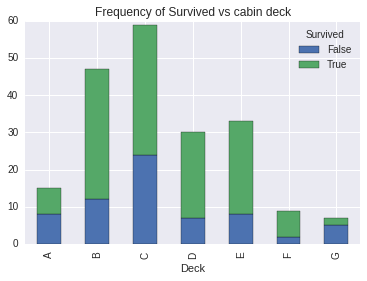

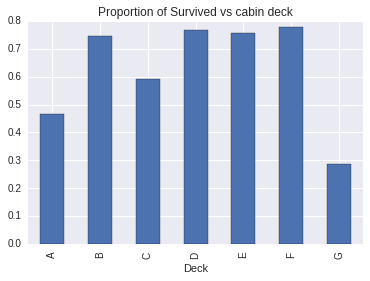

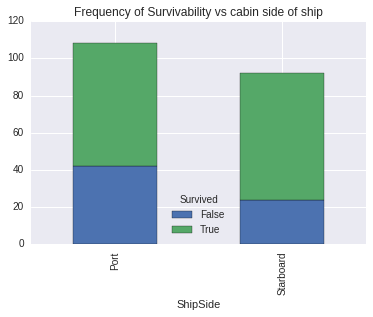

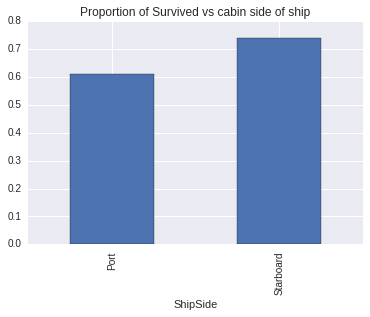

In [243]:
def convert_cabin_to_deck(cabin):
    if isinstance(cabin, float) and pd.isnull(cabin):
        return cabin
    else:
        cabins = cabin.split(' ')
        for room in cabins:
            if len(room) > 1:
                return room[0]
        return np.nan
    
def convert_cabin_to_ship_side(cabin):
    if isinstance(cabin, float) and pd.isnull(cabin):
        return cabin
    else:
        cabins = cabin.split(' ')
        for room in cabins:
            if len(room) > 1:
                if int(room[1:]) % 2 == 0:
                    return 'Port'
                else:
                    return 'Starboard'
        return np.nan

grouped_survival_cabin = df2[['Survived','Cabin','PassengerId']]
grouped_survival_cabin = grouped_survival_cabin.assign(Deck = grouped_survival_cabin['Cabin'].apply(convert_cabin_to_deck))
grouped_survival_cabin = grouped_survival_cabin.assign(ShipSide = grouped_survival_cabin['Cabin'].apply(convert_cabin_to_ship_side))
grouped_survival_deck = grouped_survival_cabin.groupby(['Survived','Deck'])['PassengerId'].count().unstack().transpose()
grouped_survival_deck.plot(kind='bar',stacked=True,title='Frequency of Survived vs cabin deck')
plt.show()
grouped_survival_deck_proportion = grouped_survival_deck[True] / grouped_survival_deck.sum(axis=1)
grouped_survival_deck_proportion.plot(kind='bar',title='Proportion of Survived vs cabin deck')
grouped_survival_shipside = grouped_survival_cabin.groupby(['Survived','ShipSide'])['PassengerId'].count().unstack().transpose()
grouped_survival_shipside.plot(kind='bar',stacked=True,title='Frequency of Survivability vs cabin side of ship')
plt.show()
grouped_survival_shipside_proportion = grouped_survival_shipside[True] / grouped_survival_shipside.sum(axis = 1)
grouped_survival_shipside_proportion.plot(kind='bar',title='Proportion of Survived vs cabin side of ship')

There appears to be a relationship between the side of the ship a cabin is located and survivability. In our sample, there are more passengers on the Port side of the ship. Furthermore, the wikipedia sources above suggest that several lifeboats on the Port side were sent partially filled.

Null Hypothesis: There is no relationship between cabin side and survivability.

Alternative Hypothesis: There is a relationship between cabin side and survivability.

We must validate our assumptions for the chi-squared test.

- [x] Observations are indepedent
- [x] Categories are mututally exclusive
- [x] Expected frequencies > 5

In [390]:
print stats.chi2_contingency(grouped_survival_shipside)
print grouped_survival_shipside.sum().sum()

(3.1262586205264111, 0.077040358396788494, 1, array([[ 35.64,  72.36],
       [ 30.36,  61.64]]))
200



$$
chi^2-squared(1,N=200) = 3.1262586205264111, P < .10
$$

At a confidence level of 95%, this is not statistically significant. We retain the Null Hypothesis that
there is no relationship between cabin side and survivability.